In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

## Read data and processing

In [93]:
data = pd.read_csv('Stars_original.csv')
data.head()

,Temperature,L,R,A_M,Color,Spectral_Class,Type
0,3068,0.002400,0.1700,16.12,Red,M,Red Dwarf
1,3042,0.000500,0.1542,16.60,Red,M,Red Dwarf
2,2600,0.000300,0.1020,18.70,Red,M,Red Dwarf
3,2800,0.000200,0.1600,16.65,Red,M,Red Dwarf
4,1939,0.000138,0.1030,20.06,Red,M,Red Dwarf


In [94]:
data['Type'].unique()

array(['Red Dwarf', 'Brown Dwarf', 'White Dwarf', 'Main Sequence',
       'Supergiant', 'Hypergiant'], dtype=object)

In [95]:
# data.to_csv('Stars_original.csv',index = False)

In [96]:
a = data.to_numpy()
a

array([[3068, 0.0024, 0.17, ..., 'Red', 'M', 'Red Dwarf'],
       [3042, 0.0005, 0.1542, ..., 'Red', 'M', 'Red Dwarf'],
       [2600, 0.0003, 0.102, ..., 'Red', 'M', 'Red Dwarf'],
       ...,
       [8829, 537493.0, 1423.0, ..., 'White', 'A', 'Hypergiant'],
       [9235, 404940.0, 1112.0, ..., 'White', 'A', 'Hypergiant'],
       [37882, 294903.0, 1783.0, ..., 'Blue', 'O', 'Hypergiant']],
      dtype=object)

In [97]:
data['Type'].unique()

array(['Red Dwarf', 'Brown Dwarf', 'White Dwarf', 'Main Sequence',
       'Supergiant', 'Hypergiant'], dtype=object)

In [98]:
# label encoding
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for i in data.columns:
    if data[i].dtype == 'object':
        data[i] = le.fit_transform(data[i])

In [99]:
data.head()

,Temperature,L,R,A_M,Color,Spectral_Class,Type
0,3068,0.002400,0.1700,16.12,8,5,3
1,3042,0.000500,0.1542,16.60,8,5,3
2,2600,0.000300,0.1020,18.70,8,5,3
3,2800,0.000200,0.1600,16.65,8,5,3
4,1939,0.000138,0.1030,20.06,8,5,3


In [100]:
data['Type'].unique()

array([3, 0, 5, 2, 4, 1])

## Training

### Extract feature

In [101]:
X,y = data.drop('Type',axis=1),data['Type']

In [102]:
X.shape

(240, 6)

### Using LDA to reduce dimensions

In [103]:
class LDA:
    '''
    Inverse transform

    Atributes:
    X_transformed: numpy array, shape = [n_samples,n_components]
    Returns:
    X_projected: numpy array, shape = [n_samples,n_features]
    
    '''
    def __init__(self,n_components):
      '''
        Parameters:
        n_components: int, default = 2

      '''
      self.n_components = n_components
      self.linear_discriminants = None
    def fit(self,X,y):

      '''
      Parameters:
      X: numpy array, shape = [n_samples,n_features]
      y: numpy array, shape = [n_samples,]
      '''
      n_features = X.shape[1]
      class_lables = np.unique(y)

      # S_W , S_B
      mean_overall = np.mean(X,axis = 0)
      S_W = np.zeros((n_features,n_features))
      S_B = np.zeros((n_features,n_features))

      for c in class_lables:
        X_c = X[y == c]
        mean_c = np.mean(X_c,axis = 0)
        # 4,4
        S_W += (X_c - mean_c).T.dot(X_c - mean_c)
        n_c = X_c.shape[0]
        mean_diff = (mean_c - mean_overall).reshape(n_features,1)
        S_B += n_c * (mean_diff).dot(mean_diff.T)
      A = np.linalg.inv(S_W).dot(S_B)
      # Same PCA
      eigenvalues,eigenveactors = np.linalg.eig(A)
      eigenveactors = eigenveactors.T
      indexs = np.argsort(abs(eigenvalues))[::-1]
      eigenvalues = eigenvalues[indexs]
      eigenvectors = eigenveactors[indexs]
      self.linear_discriminants = eigenvectors[0:self.n_components]

    def transform(self,X):

      '''
      Parameters:
      X: numpy array, shape = [n_samples,n_features]
      '''
      return np.dot(X,self.linear_discriminants.T)

In [104]:
lda = LDA(n_components=5)
lda.fit(X.to_numpy(),y)
X = lda.transform(X.to_numpy())
y = y.to_numpy()

In [105]:
# Train test split
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [106]:
print(np.unique(y))

[0 1 2 3 4 5]


### Logistic Regression

In [107]:
import numpy as np
import matplotlib.pyplot as plt

class MultiClassLogisticRegression:
    
    def __init__(self, n_iter = 10000, thres=1e-3):
        self.n_iter = n_iter
        self.thres = thres
    
    def fit(self, X, y, batch_size=64, lr=0.001, rand_seed=4, verbose=False): 
        np.random.seed(rand_seed) 
        self.classes = np.unique(y)
        self.class_labels = {c:i for i,c in enumerate(self.classes)}
        X = self.add_bias(X)
        y = self.one_hot(y)
        self.loss = []
        self.weights = np.zeros(shape=(len(self.classes),X.shape[1]))
        self.fit_data(X, y, batch_size, lr, verbose)
        return self
 
    def fit_data(self, X, y, batch_size, lr, verbose):
        i = 0
        while (not self.n_iter or i < self.n_iter):
            self.loss.append(self.cross_entropy(y, self.predict_(X)))
            idx = np.random.choice(X.shape[0], batch_size)
            X_batch, y_batch = X[idx], y[idx]
            error = y_batch - self.predict_(X_batch)
            update = (lr * np.dot(error.T, X_batch))
            self.weights += update
            if np.abs(update).max() < self.thres: break
            
            if i % 1000 == 0 and verbose: 
                print(X.shape)
                print(y)
                print(' Training Accuray at {} iterations is {}'.format(i, self.evaluate_(X, y)))
            i +=1
    
    def predict(self, X):
        return self.predict_(self.add_bias(X))
    
    def predict_(self, X):
        pre_vals = np.dot(X, self.weights.T).reshape(-1,len(self.classes))
        return self.softmax(pre_vals)
    
    def softmax(self, z):
        return np.exp(z) / np.sum(np.exp(z), axis=1).reshape(-1,1)

    def predict_classes(self, X):
        self.probs_ = self.predict(X)
        return np.vectorize(lambda c: self.classes[c])(np.argmax(self.probs_, axis=1))
  
    def add_bias(self,X):
        return np.insert(X, 0, 1, axis=1)
  
    def get_randon_weights(self, row, col):
        return np.zeros(shape=(row,col))

    def one_hot(self, y):
        return np.eye(len(self.classes))[np.vectorize(lambda c: self.class_labels[c])(y).reshape(-1)]
    
    def score(self, X, y):
        return np.mean(self.predict_classes(X) == y)
    
    def evaluate_(self, X, y):
        return np.mean(np.argmax(self.predict_(X), axis=1) == np.argmax(y, axis=1))
    
    def cross_entropy(self, y, probs):
        return -1 * np.mean(y * np.log(probs))

In [108]:
multi = MultiClassLogisticRegression(n_iter=1001)
multi.fit(X_train,y_train,lr=0.001,verbose=True)
print('Score: ',multi.score(X_test,y_test))

(192, 6)
[[1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 ...
 [0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]]
 Training Accuray at 0 iterations is 0.375
Score:  0.9791666666666666


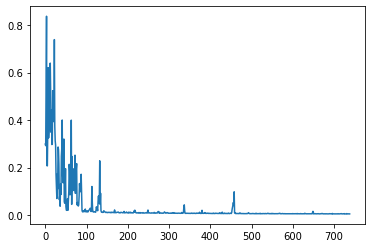

In [109]:
plt.plot(multi.loss)